## Imports

In [1]:
import numpy as np
import pandas as pd
import csv
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor

%matplotlib inline

In [2]:
import os
from dotenv import load_dotenv
import nltk as nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
from newsapi import NewsApiClient

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\pauli\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
# Read your api key environment variable
load_dotenv()
api_key = os.getenv("NEWS_API_KEY")

## Read Data

In [4]:
house_df = pd.read_csv('aus-property-sales-sep2018-april2020.csv', index_col="date_sold", infer_datetime_format=True, parse_dates=True)

In [5]:
# perform clean
house_df = house_df.replace(-np.inf, np.nan).dropna()
house_df.isnull().sum()

price            0
suburb           0
city_name        0
state            0
lat              0
lon              0
bedrooms         0
property_type    0
loc_pid          0
lga_pid          0
dtype: int64

## Exploratory Data Analysis

In [6]:
house_df.head()

,price,suburb,city_name,state,lat,lon,bedrooms,property_type,loc_pid,lga_pid
date_sold,,,,,,,,,,
2018-09-26,1730000.0,Darling Point,Sydney,NSW,-33.868386,151.237471,2,unit,NSW1221,NSW180
2018-09-26,1928000.0,Darling Point,Sydney,NSW,-33.875465,151.236280,3,unit,NSW1221,NSW180
2018-10-02,1475000.0,Darling Point,Sydney,NSW,-33.875734,151.233575,3,unit,NSW1221,NSW180
2018-10-12,960000.0,Darling Point,Sydney,NSW,-33.869516,151.237239,2,unit,NSW1221,NSW180
2018-10-25,1615000.0,Darling Point,Sydney,NSW,-33.876785,151.233727,2,unit,NSW1221,NSW180


In [7]:
house_df.shape

(257773, 10)

In [8]:
house_df.describe().round(1)

,price,lat,lon,bedrooms
count,257773.0,257773.0,257773.0,257773.0
mean,810703.0,-34.7,143.9,3.1
std,618590.9,3.2,10.4,1.0
min,1000.0,-38.5,115.6,0.0
25%,486000.0,-37.8,144.8,2.0
50%,655000.0,-34.8,145.2,3.0
75%,920000.0,-33.7,151.1,4.0
max,100000000.0,-27.3,153.2,5.0


In [9]:
df_2020 = house_df.loc['2020']
df_2020

,price,suburb,city_name,state,lat,lon,bedrooms,property_type,loc_pid,lga_pid
date_sold,,,,,,,,,,
2020-02-04,2713000.0,Darling Point,Sydney,NSW,-33.876972,151.235154,3,unit,NSW1221,NSW180
2020-02-12,1675000.0,Darling Point,Sydney,NSW,-33.872669,151.236598,2,unit,NSW1221,NSW180
2020-02-13,1305000.0,Darling Point,Sydney,NSW,-33.876576,151.234109,2,unit,NSW1221,NSW180
2020-02-14,1525000.0,Darling Point,Sydney,NSW,-33.870298,151.238971,2,unit,NSW1221,NSW180
2020-02-21,1486012.0,Darling Point,Sydney,NSW,-33.872048,151.237485,2,unit,NSW1221,NSW180
...,...,...,...,...,...,...,...,...,...,...
2020-07-02,507000.0,Moncrieff,Canberra,ACT,-35.154495,149.120079,3,townhouse,ACT932,ACT
2020-07-08,497000.0,Moncrieff,Canberra,ACT,-35.154065,149.113763,3,townhouse,ACT932,ACT
2020-07-09,400000.0,Moncrieff,Canberra,ACT,-35.153879,149.114604,2,townhouse,ACT932,ACT


In [10]:
group_by =house_df.groupby([(house_df.index.year),(house_df.index.month)]).mean()

group_by

price        lat         lon  bedrooms
date_sold date_sold                                                
2018      9          850007.916574 -34.682413  144.112957  3.107882
          10         829478.492053 -34.801399  144.016411  3.100240
          11         839480.032358 -34.606681  144.038427  3.138407
          12         785310.668929 -34.646287  143.399979  3.115454
2019      1          675778.700042 -34.374346  142.267287  3.133879
          2          763048.675156 -34.584443  143.788077  3.082847
          3          794212.491691 -34.607818  144.121949  3.104076
          4          760107.130057 -34.517010  144.012153  3.102346
          5          734185.244651 -34.733314  143.820622  3.084747
          6          757711.014234 -34.674994  143.891080  3.125716
          7          730226.215898 -34.610864  143.916397  3.081247
          8          786966.061746 -34.748312  144.076206  3.111257
          9          845477.204562 -34.695548  144.155841  3.126746
          10         876602.806251 -34.870990  144.065033  3.120392
          11         928715.008451 -34.809317  144.618892  3.122651
          12         847415.146413 -34.800089  143.780152  3.134516
2020      1          705230.369083 -34.282132  142.160030  3.104781
          2          873721.658022 -34.762295  144.170089  3.066044
          3          853169.722031 -34.647695  144.033390  3.070315
          4          793363.352934 -34.494305  143.493725  3.105399
          5          769267.869856 -34.708701  144.265124  3.100521
          6          770303.661982 -34.795428  144.379310  3.072207
          7          796892.633736 -35.030674  144.102583  3.112946

C:\ProgramData\Anaconda3\envs\mlenv\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='price'>

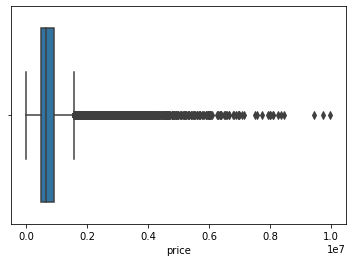

In [11]:
sns.boxplot(df_2020['price'])

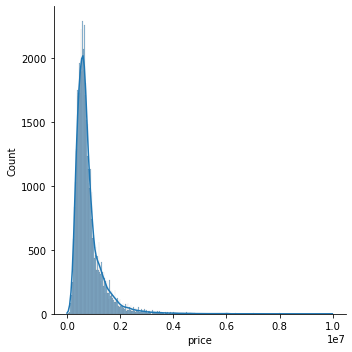

In [12]:
sns.displot(df_2020['price'],kde=True)

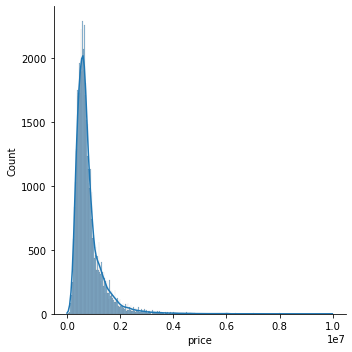

In [39]:
sns.displot(df_2020['price'],kde=True)

<AxesSubplot:ylabel='price'>

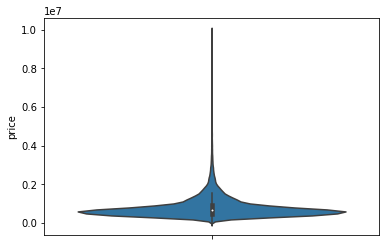

In [40]:
#plt = figure(figsize=(10,6))
sns.violinplot(data=df_2020,y='price')

In [43]:
df_2020['suburb'].value_counts().head(15)

Pakenham       461
Craigieburn    331
Frankston      322
Sunbury        290
Werribee       274
Point Cook     265
Tarneit        261
Berwick        257
Melbourne      254
Epping         249
Croydon        247
Reservoir      246
Wollert        237
Dee Why        222
Mornington     212
Name: suburb, dtype: int64

## Feature Engineering and Selection

In [13]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import chi2_contingency

In [14]:
#Test Features using ChiSquare Test
class ChiSquare:
    def __init__(self, dataframe):
        self.df = dataframe
        self.p = None #P-Value
        self.chi2 = None #Chi Test Statistic
        self.dof = None
        
        self.dfObserved = None
        self.dfExpected = None
        
    def _print_chisquare_result(self, colX, alpha):
        result = ""
        if self.p<alpha:
            result="{0} is IMPORTANT for Prediction".format(colX)
        else:
            result="{0} is NOT an important predictor. (Discard {0} from model)".format(colX)
        print(result)
        
    def TestIndependence(self,colX,colY, alpha=0.05):
        X = self.df[colX].astype(str)
        Y = self.df[colY].astype(str)
        
        self.dfObserved = pd.crosstab(Y,X) 
        chi2, p, dof, expected = stats.chi2_contingency(self.dfObserved.values)
        self.p = p
        self.chi2 = chi2
        self.dof = dof 
        
        self.dfExpected = pd.DataFrame(expected, columns=self.dfObserved.columns, index = self.dfObserved.index)
        
        self._print_chisquare_result(colX,alpha)
        
#df = pd.pandas.read_csv("train.csv")
#df['dummyCat'] = np.random.choice([0, 1], size=(len(df),), p=[0.5, 0.5])
#Initialize ChiSquare Class
cT = ChiSquare(df_2020)
#Feature Selection
testColumns = ['suburb', 'city_name', 'state', 'lat', 'lon', 'bedrooms',
       'property_type', 'loc_pid', 'lga_pid']
for var in testColumns:
    cT.TestIndependence(colX=var,colY='price' ) 

suburb is IMPORTANT for Prediction
city_name is IMPORTANT for Prediction
state is IMPORTANT for Prediction
lat is IMPORTANT for Prediction
lon is IMPORTANT for Prediction
bedrooms is IMPORTANT for Prediction
property_type is IMPORTANT for Prediction
loc_pid is IMPORTANT for Prediction
lga_pid is IMPORTANT for Prediction


## Sentiment Analysis

In [15]:
# Create a newsapi client
newsapi = NewsApiClient(api_key=api_key)

In [16]:
house_price_news = newsapi.get_everything(
    q='Australia home prices',
    language="en")

# Show the total number of news articles
house_price_news["totalResults"]

955

In [17]:
house_price_sentiments = []

for article in house_price_news["articles"]:
    try:
        text = article["content"]
        date = article["publishedAt"][:10]
        sentiment = analyzer.polarity_scores(text)
        compound = sentiment["compound"]
        pos = sentiment["pos"]
        neu = sentiment["neu"]
        neg = sentiment["neg"]
        
        house_price_sentiments.append({
            "text": text,
            "date": date,
            "compound": compound,
            "positive": pos,
            "negative": neg,
            "neutral": neu
            
        })
        
    except AttributeError:
        pass

In [18]:
# Create DataFrame
house_price_news_df = pd.DataFrame(house_price_sentiments)

# Reorder DataFrame columns
cols = ["date", "text", "compound", "positive", "negative", "neutral"]
house_price_news_df = house_price_news_df[cols]

house_price_news_df

,date,text,compound,positive,negative,neutral
0,2021-03-03,"SYDNEY, March 3 (Reuters) - The Australian and...",0.4939,0.096,0.000,0.904
1,2021-03-01,* Home prices rise by the fastest since August...,0.2732,0.057,0.030,0.914
2,2021-02-19,"SYDNEY, Feb 19 (Reuters) - The Australian and ...",0.0000,0.000,0.000,1.000
3,2021-02-25,"SYDNEY, Feb 25 (Reuters) - The Australian and ...",0.2500,0.059,0.000,0.941
4,2021-02-11,"SYDNEY, Feb 11 (Reuters) - Australias housing ...",-0.4215,0.000,0.080,0.920
5,2021-02-15,* Nearmap sees best day in 2-1/2 years\r\n* Be...,0.6597,0.189,0.113,0.698
6,2021-03-01,* Aussie benchmark posts biggest gain since Ja...,0.6908,0.174,0.000,0.826
7,2021-02-16,By Reuters Staff\r\n(Adds background on housin...,0.4404,0.088,0.000,0.912
8,2021-02-05,By Reuters Staff\r\nFILE PHOTO: A beach can be...,0.0000,0.000,0.000,1.000
9,2021-02-11,"LAUNCESTON, Australia (Reuters) - The closure ...",0.0000,0.000,0.000,1.000


In [36]:
house_price_news_df.describe()

,compound,positive,negative,neutral
count,20.000000,20.000000,20.000000,20.000000
mean,0.183105,0.076350,0.036900,0.886750
std,0.427464,0.089237,0.046729,0.113078
min,-0.624900,0.000000,0.000000,0.659000
25%,0.000000,0.000000,0.000000,0.822250
50%,0.125000,0.048000,0.000000,0.913000
75%,0.498075,0.167250,0.077000,1.000000
max,0.812600,0.273000,0.129000,1.000000


In [49]:
house_price_news_df

,date,text,compound,positive,negative,neutral
0,2021-03-03,"SYDNEY, March 3 (Reuters) - The Australian and...",0.4939,0.096,0.000,0.904
1,2021-03-01,* Home prices rise by the fastest since August...,0.2732,0.057,0.030,0.914
2,2021-02-19,"SYDNEY, Feb 19 (Reuters) - The Australian and ...",0.0000,0.000,0.000,1.000
3,2021-02-25,"SYDNEY, Feb 25 (Reuters) - The Australian and ...",0.2500,0.059,0.000,0.941
4,2021-02-11,"SYDNEY, Feb 11 (Reuters) - Australias housing ...",-0.4215,0.000,0.080,0.920
5,2021-02-15,* Nearmap sees best day in 2-1/2 years\r\n* Be...,0.6597,0.189,0.113,0.698
6,2021-03-01,* Aussie benchmark posts biggest gain since Ja...,0.6908,0.174,0.000,0.826
7,2021-02-16,By Reuters Staff\r\n(Adds background on housin...,0.4404,0.088,0.000,0.912
8,2021-02-05,By Reuters Staff\r\nFILE PHOTO: A beach can be...,0.0000,0.000,0.000,1.000
9,2021-02-11,"LAUNCESTON, Australia (Reuters) - The closure ...",0.0000,0.000,0.000,1.000


In [45]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [15.0, 10.0]

In [46]:
# adding specific stopwords
stopwords = set(STOPWORDS)
stopwords.add("int")
stopwords.add("ext")

stopwords.add('file')
stopwords.add('photo')
stopwords.add('image')
stopwords.add('reuters')
stopwords.add('whiskey')
stopwords.add('chars')
stopwords.add('Staff')

In [47]:
#Create Word Cloud
df_cloud = WordCloud(stopwords=stopwords, background_color="white").generate(house_price_news_df["text"].str.cat())

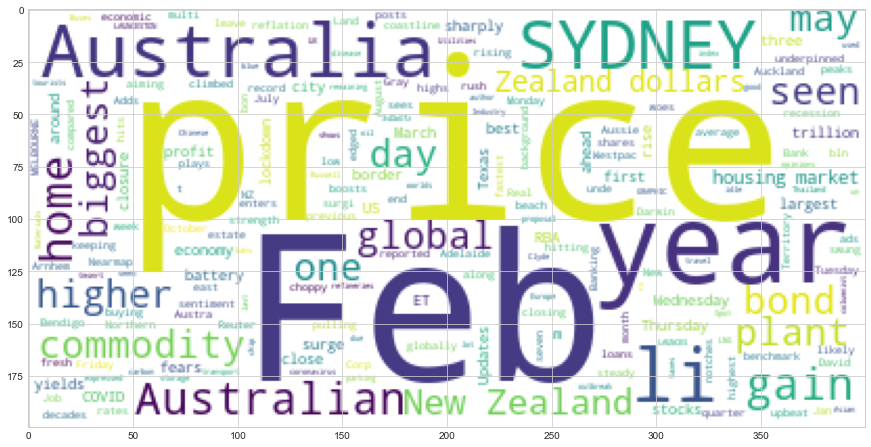

In [48]:
plt.imshow(df_cloud)

In [ ]:
wordcloud = WordCloud(stopwords=stopwords).generate(house_price_news_df["text"].str.cat())
plt.imshow(wordcloud)
plt.axis('off')

In [ ]:
X = house_df.drop("price", 1)
Y = house_df["price"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.70)

In [ ]:
 def window_data(df, window, feature_col_number, target_col_number):
    """
    This function accepts the column number for the features (X) and the target (y).
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    """
    X = []
    y = []
    for i in range(len(df) - window):
        features = df.iloc[i : (i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)


# Define the window size
window_size = 90

# Set the index of the feature and target columns
feature_column = 0
target_column = 0

# Create the features (X) and target (y) data using the window_data() function.
X, y = window_data(house_data, window_size, feature_column, target_column)

# Print a few sample values from X and y
print (f"X sample values:\n{X[:3]} \n")
print (f"y sample values:\n{y[:3]}")

In [ ]:
 # Manually splitting the data
split = int(0.7 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

In [ ]:
# Use the MinMaxScaler to scale data between 0 and 1.
from sklearn.preprocessing import MinMaxScaler
x_train_scaler = MinMaxScaler()
x_test_scaler = MinMaxScaler()
y_train_scaler = MinMaxScaler()
y_test_scaler = MinMaxScaler()

# Fit the scaler for the Training Data
x_train_scaler.fit(X_train)
y_train_scaler.fit(y_train)

# Scale the training data
X_train = x_train_scaler.transform(X_train)
y_train = y_train_scaler.transform(y_train)

# Fit the scaler for the Testing Data
x_test_scaler.fit(X_test)
y_test_scaler.fit(y_test)

# Scale the y_test data
X_test = x_test_scaler.transform(X_test)
y_test = y_test_scaler.transform(y_test)

In [ ]:
 # Reshape the features data
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Print some sample data after reshaping the datasets
print (f"X_train sample values:\n{X_train[:3]} \n")
print (f"X_test sample values:\n{X_test[:3]}")

In [44]:
 # Importing required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout